In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
import re
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [3]:
STOPWORDS = stopwords.words('english')

In [4]:
reviews = pd.read_json('scrapped_reviews/scrapped reviews_datasets/sarova_hotel_reviews.json')

In [5]:
reviews.head()

,hotel,review,title,rating,date
0,Sarova Whitesands Beach Resort & Spa,Just landed in the country and my first lunch ...,Refreshing Getaway,50,2021-03-01
1,Sarova Whitesands Beach Resort & Spa,"High speed WiFi is myth, complaints about it w...",Does not meet my expectations,30,2021-03-01
2,Sarova Whitesands Beach Resort & Spa,Thank you to all the white sands staff for the...,Relaxing & spoilt,40,2020-12-01
3,Sarova Whitesands Beach Resort & Spa,We travelled as a family for a few days togeth...,Fantastic Stay,50,2021-02-01
4,Sarova Whitesands Beach Resort & Spa,It's a beautiful place despite the fact that c...,My five days stay at Sarova whitesands hotel,50,2021-02-01


In [6]:
reviews.shape

(4976, 5)

In [7]:
reviews.shape

(4976, 5)

### Data Preprocessing and EDA

In [8]:
# Check for null values
reviews.isnull().sum()

hotel     0
review    0
title     0
rating    0
date      0
dtype: int64

#### Observations:
* No null values in the dataframe

In [9]:
# Look at some summary statistics on the data
reviews.describe()

,rating
count,4976.000000
mean,44.045418
std,8.836491
min,10.000000
25%,40.000000
50%,50.000000
75%,50.000000
max,50.000000


In [10]:
reviews.describe(exclude=np.number)

<ipython-input-10-59d8f888ae30>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  reviews.describe(exclude=np.number)


,hotel,review,title,date
count,4976,4976,4976,4976
unique,5,4975,4515,182
top,Sarova Stanley,amazing property with a very friendly staff. j...,Excellent,2019-07-01 00:00:00
freq,1351,2,17,79
first,NaN,NaN,NaN,2003-02-01 00:00:00
last,NaN,NaN,NaN,2021-03-01 00:00:00


#### Observations:
* There seems to be duplicate reviews and review titles

In [11]:
# Check for duplicated reviews
duplicated_idx = reviews[reviews['review'].duplicated(keep='first')].index

In [12]:
# Drop duplicated rows
reviews = reviews.drop(duplicated_idx, axis=0)

In [13]:
reviews.shape

(4975, 5)

<AxesSubplot:xlabel='hotel'>

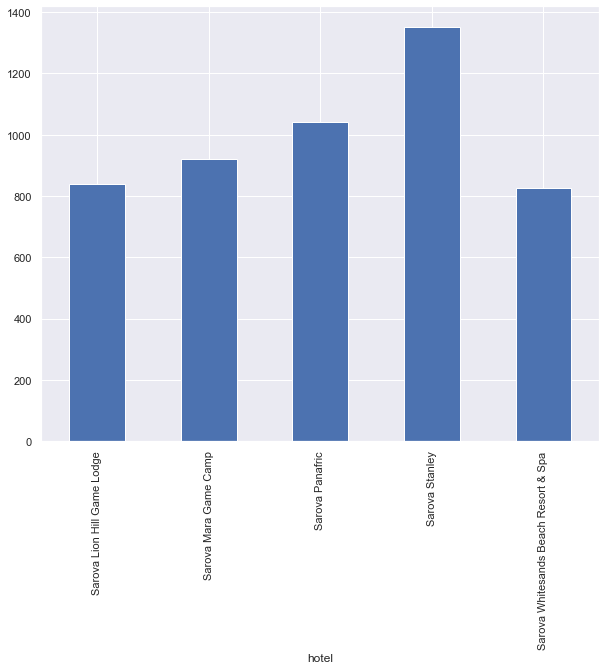

In [14]:
# Look at the distribution of reviews per hotel
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()

reviews.groupby('hotel')['review'].count().plot(kind='bar', ax=ax)

#### Observations:
* Sarova Stanley has the most reviews

In [15]:
# Convert ratings to  a 5 point scale
reviews['rating'] = reviews['rating'] / 10

In [16]:
reviews.head(3)

,hotel,review,title,rating,date
0,Sarova Whitesands Beach Resort & Spa,Just landed in the country and my first lunch ...,Refreshing Getaway,5.0,2021-03-01
1,Sarova Whitesands Beach Resort & Spa,"High speed WiFi is myth, complaints about it w...",Does not meet my expectations,3.0,2021-03-01
2,Sarova Whitesands Beach Resort & Spa,Thank you to all the white sands staff for the...,Relaxing & spoilt,4.0,2020-12-01


<AxesSubplot:>

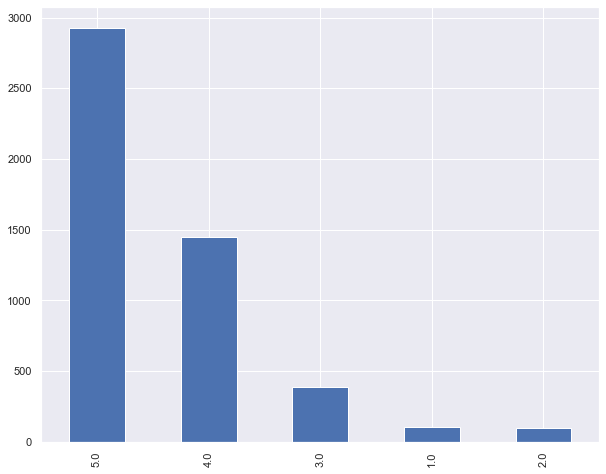

In [17]:
# Look at the distribution of ratings
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()

reviews['rating'].value_counts().plot(kind='bar', ax=ax)

In [18]:
# Review distribution percentage
rating_counts = reviews['rating'].value_counts()
total = reviews.shape[0]
percentage = rating_counts / total * 100

pd.concat([rating_counts, percentage], axis=1, keys=['Total', 'Percentage'])

,Total,Percentage
5.0,2928,58.854271
4.0,1449,29.125628
3.0,389,7.819095
1.0,109,2.190955
2.0,100,2.010050


#### Observation:
* Classes are heavily imbalanced
* Reviews with ratings 1,2 and 3 constitute approx 12% of the entire reviews

<AxesSubplot:xlabel='hotel', ylabel='review'>

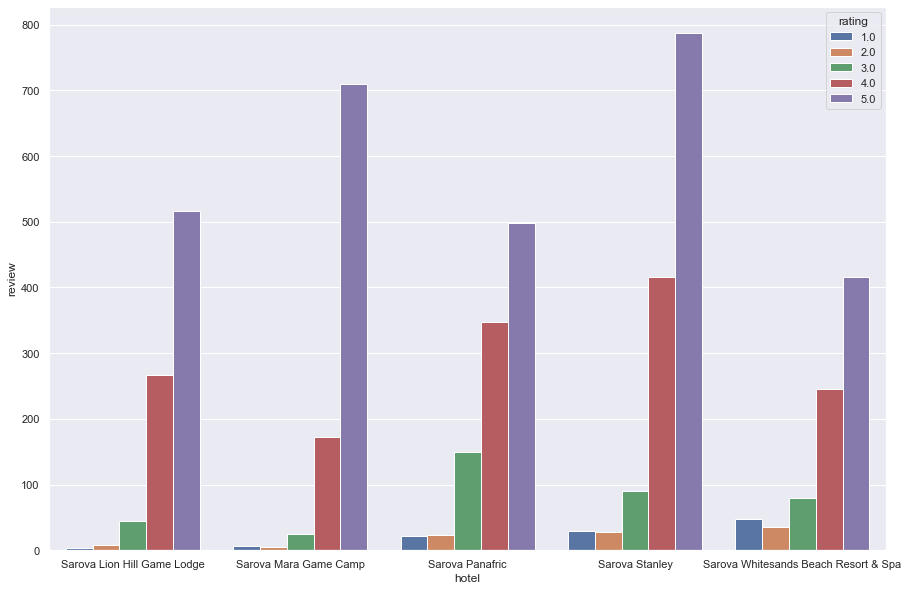

In [19]:
# Look at the distribution of ratings per hotel
hotel_ratings = reviews.groupby(['hotel', 'rating'])['review'].count().reset_index()

fig = plt.figure(figsize=(15, 10))
ax = fig.gca()

sns.barplot(data=hotel_ratings, x='hotel', y='review', hue='rating')

In [20]:
reviews.head(3)

,hotel,review,title,rating,date
0,Sarova Whitesands Beach Resort & Spa,Just landed in the country and my first lunch ...,Refreshing Getaway,5.0,2021-03-01
1,Sarova Whitesands Beach Resort & Spa,"High speed WiFi is myth, complaints about it w...",Does not meet my expectations,3.0,2021-03-01
2,Sarova Whitesands Beach Resort & Spa,Thank you to all the white sands staff for the...,Relaxing & spoilt,4.0,2020-12-01


In [21]:
# Convert date to datetime
reviews['date'] = pd.to_datetime(reviews['date'])

In [22]:
hotel_ratings

,hotel,rating,review
0,Sarova Lion Hill Game Lodge,1.0,4
1,Sarova Lion Hill Game Lodge,2.0,8
2,Sarova Lion Hill Game Lodge,3.0,45
3,Sarova Lion Hill Game Lodge,4.0,266
4,Sarova Lion Hill Game Lodge,5.0,516
5,Sarova Mara Game Camp,1.0,7
6,Sarova Mara Game Camp,2.0,5
7,Sarova Mara Game Camp,3.0,25
8,Sarova Mara Game Camp,4.0,173
9,Sarova Mara Game Camp,5.0,710


In [23]:
# Create a month and year column from the datetime
reviews['month'] = reviews['date'].dt.month
reviews['year'] = reviews['date'].dt.year

<AxesSubplot:xlabel='month'>

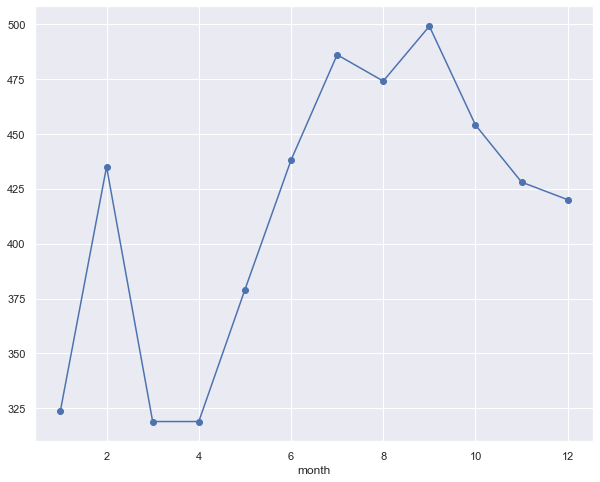

In [24]:
# Group reviews by month
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()

reviews.groupby('month')['review'].count().plot(kind='line', marker='o')

In [25]:
reviews.head(3)

,hotel,review,title,rating,date,month,year
0,Sarova Whitesands Beach Resort & Spa,Just landed in the country and my first lunch ...,Refreshing Getaway,5.0,2021-03-01,3,2021
1,Sarova Whitesands Beach Resort & Spa,"High speed WiFi is myth, complaints about it w...",Does not meet my expectations,3.0,2021-03-01,3,2021
2,Sarova Whitesands Beach Resort & Spa,Thank you to all the white sands staff for the...,Relaxing & spoilt,4.0,2020-12-01,12,2020


#### Observations:
* July to September are the months with the most reviews
* March and April are the months with the least reviews

<AxesSubplot:xlabel='year'>

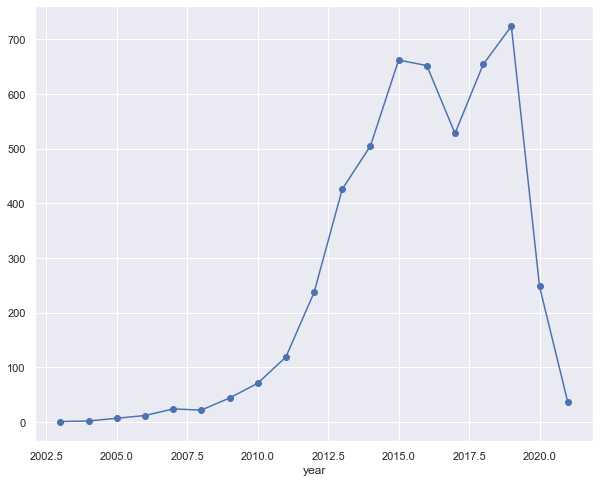

In [26]:
# Group reviews by month
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()

reviews.groupby('year')['review'].count().plot(kind='line', marker='o')

#### Observations:
* 2015 to 2019 were the years with most reviews given to the hotels
* There was a drop in the number of reviews is 2020 which could be attributed to the current pandemic and hotel tourism restrictions
* 2021 is still young hence the low number of reviews

In [27]:
reviews.head(2)

,hotel,review,title,rating,date,month,year
0,Sarova Whitesands Beach Resort & Spa,Just landed in the country and my first lunch ...,Refreshing Getaway,5.0,2021-03-01,3,2021
1,Sarova Whitesands Beach Resort & Spa,"High speed WiFi is myth, complaints about it w...",Does not meet my expectations,3.0,2021-03-01,3,2021


### EDA on Reviews

In [28]:
# Dictionary mapping word contractions to their full words
contractions = { 
    "ain't": "are not","'s":" is","aren't": "are not",
     "can't": "cannot","can't've": "cannot have",
     "'cause": "because","could've": "could have","couldn't": "could not",
     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
     "hasn't": "has not","haven't": "have not","he'd": "he would",
     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
     "it'd": "it would","it'd've": "it would have","it'll": "it will",
     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
     "mayn't": "may not","might've": "might have","mightn't": "might not", 
     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
     "mustn't've": "must not have", "needn't": "need not",
     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
     "she'll": "she will", "she'll've": "she will have","should've": "should have",
     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
     "there'd've": "there would have", "they'd": "they would",
     "they'd've": "they would have","they'll": "they will",
     "they'll've": "they will have", "they're": "they are","they've": "they have",
     "to've": "to have","wasn't": "was not","we'd": "we would",
     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
     "what'll've": "what will have","what're": "what are", "what've": "what have",
     "when've": "when have","where'd": "where did", "where've": "where have",
     "who'll": "who will","who'll've": "who will have","who've": "who have",
     "why've": "why have","will've": "will have","won't": "will not",
     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
     "y'all'd've": "you all would have","y'all're": "you all are",
     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
     "you'll": "you will","you'll've": "you will have", "you're": "you are",
     "you've": "you have"
}

In [29]:
# Remove punctutation marks, stopwords, emojis, urls, convert to lowercase, expand contractions, hashtags, retweet
def preprocess_review(review):
    res_review = []
    lemmatizer = WordNetLemmatizer()
    
    for word in review.split():        
        
        # Expand Contractions
        word = contractions.get(word.lower(), word)
        
        # Remove stopwords
        if word not in STOPWORDS:
            
            # Remove punctuation
            word = re.sub(r'[^\w\s]', '', word)
            
            # Convert to lowercase
            word = word.lower()
            
            # Lemmatize the word
            word = lemmatizer.lemmatize(word, pos='v')
        
            if word != '':
                res_review.append(word)

    return ' '.join([word for word in res_review]) 

In [40]:
# Preprocess the reviews
reviews['review'] = reviews['review'].apply(lambda x: preprocess_review(x))

In [41]:
reviews.head(2)

,hotel,review,title,rating,date,month,year
0,Sarova Whitesands Beach Resort & Spa,land country first lunch lido restaurant besid...,refresh getaway,5.0,2021-03-01,3,2021
1,Sarova Whitesands Beach Resort & Spa,high speed wifi myth complaints dismiss advise...,do meet expectations,3.0,2021-03-01,3,2021


In [42]:
# Preprocess the review titles
reviews['title'] = reviews['title'].apply(lambda x: preprocess_review(x))

In [43]:
reviews.head(2)

,hotel,review,title,rating,date,month,year
0,Sarova Whitesands Beach Resort & Spa,land country first lunch lido restaurant besid...,refresh getaway,5.0,2021-03-01,3,2021
1,Sarova Whitesands Beach Resort & Spa,high speed wifi myth complaints dismiss advise...,meet expectations,3.0,2021-03-01,3,2021


In [45]:
review_tokens = [token for review in reviews['review'].values for token in review.split()]
fdist = FreqDist(review_tokens)

In [46]:
fdist

FreqDist({'room': 4295, 'hotel': 4179, 'stay': 3718, 'staff': 3548, 'good': 2588, 'food': 2423, 'great': 2163, 'service': 1931, 'sarova': 1533, 'time': 1512, ...})

<AxesSubplot:>

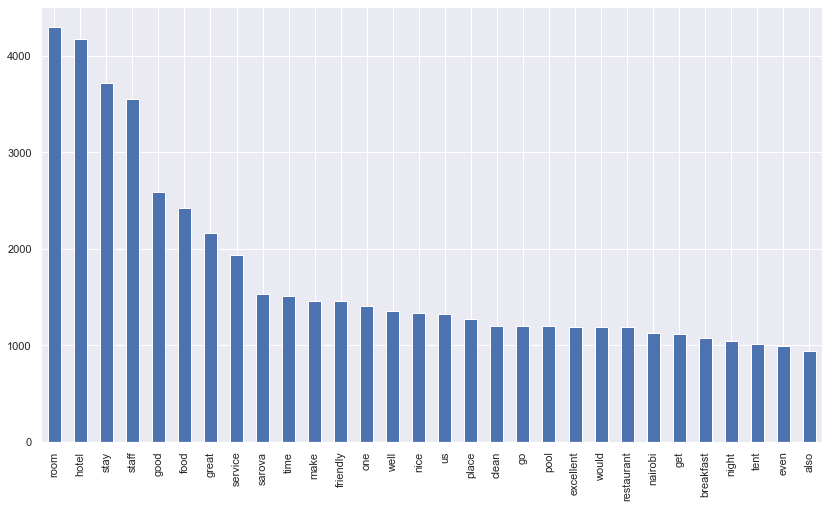

In [47]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()

pd.Series(dict(fdist.most_common(30))).plot(kind='bar', ax=ax)

In [48]:
title_tokens = [token for title in reviews['title'].values for token in title.split()]
fdist_title = FreqDist(title_tokens)

<AxesSubplot:>

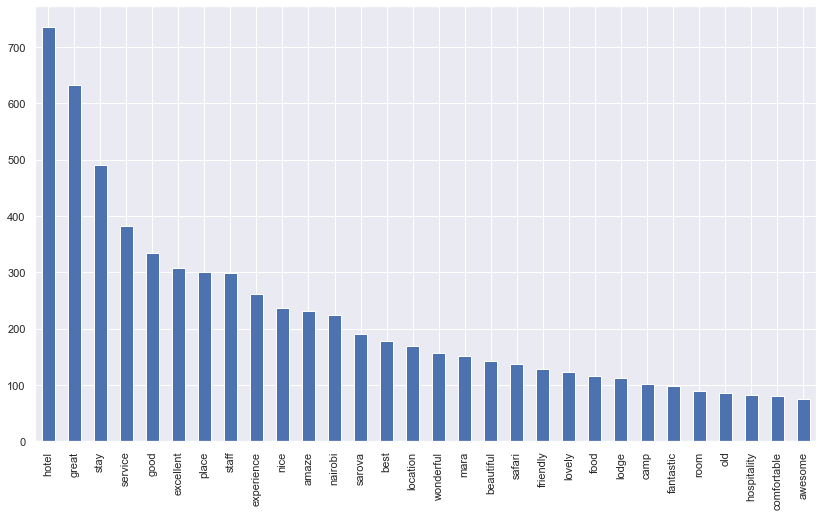

In [49]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()

pd.Series(dict(fdist_title.most_common(30))).plot(kind='bar', ax=ax)

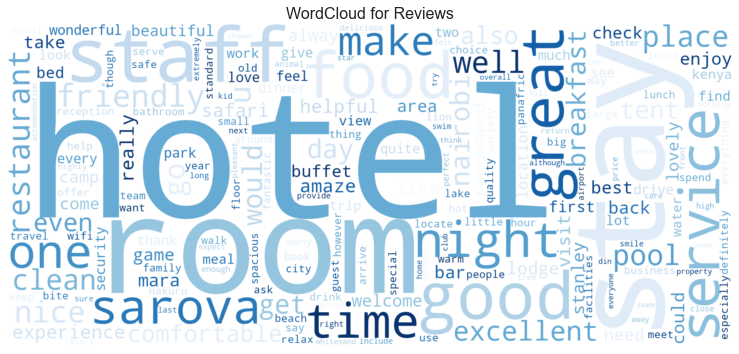

In [57]:
# Word cloud of words in the reviews
plt.subplots(figsize=(13,13))
text = reviews['review'].tolist()
wc = WordCloud(
  stopwords=STOPWORDS,
  background_color='white',
  colormap='Blues',
  collocations=False,
  width=1800,
  height=800
)
wc.generate(' '.join(text))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.title("WordCloud for Reviews",fontsize=16)
plt.show()

In [67]:
def display_cloud(label, df, col):
    plt.subplots(figsize=(13,13))
    text = df[df['rating']==label][col].tolist()
    wc = WordCloud(
      stopwords=STOPWORDS,
      background_color='white',
      colormap='Blues',
      collocations=False,
      width=1800,
      height=800,
    )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title("WordCloud for Rating " + str(label), fontsize=24)
    plt.show()

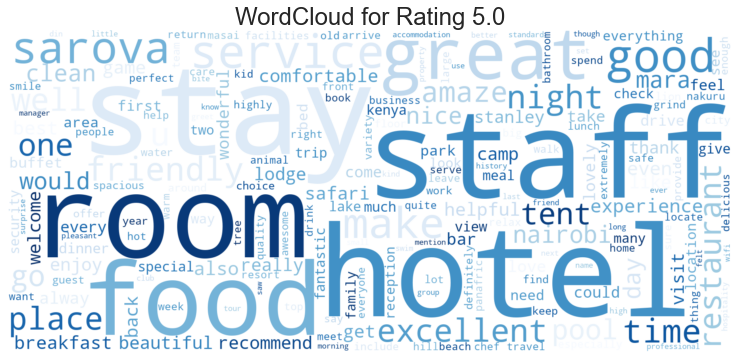

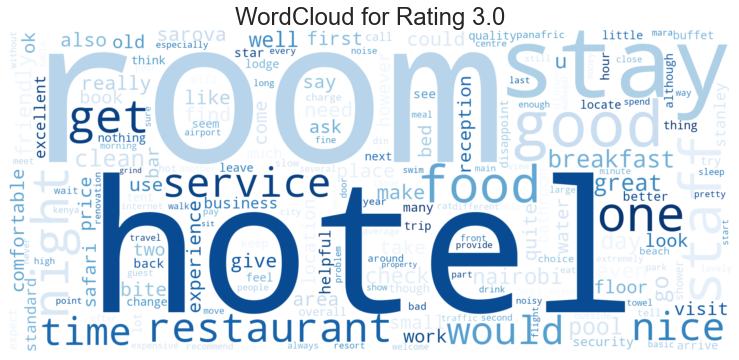

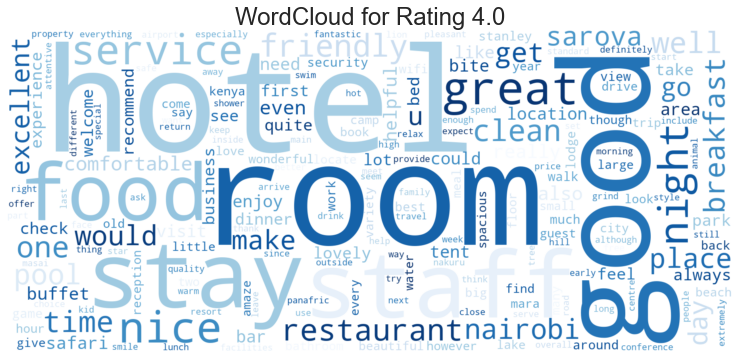

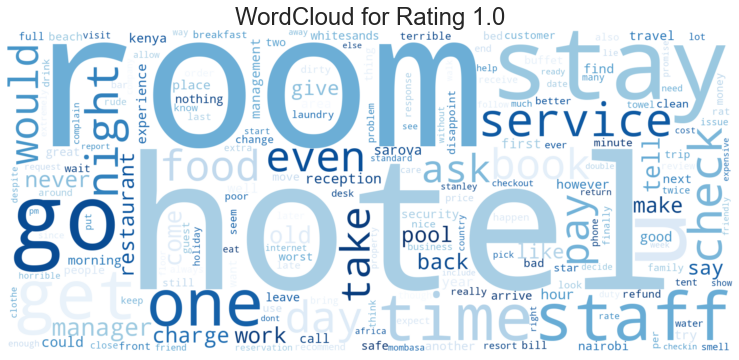

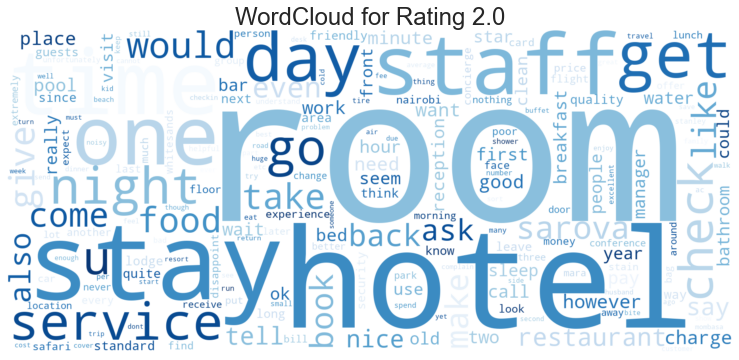

In [68]:
for rating in reviews['rating'].unique():
    display_cloud(rating, reviews, 'review')

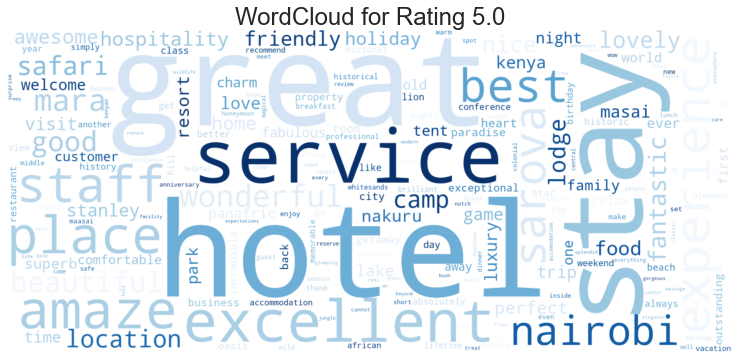

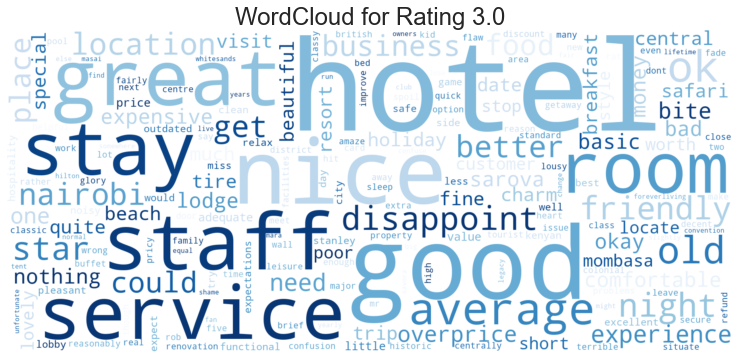

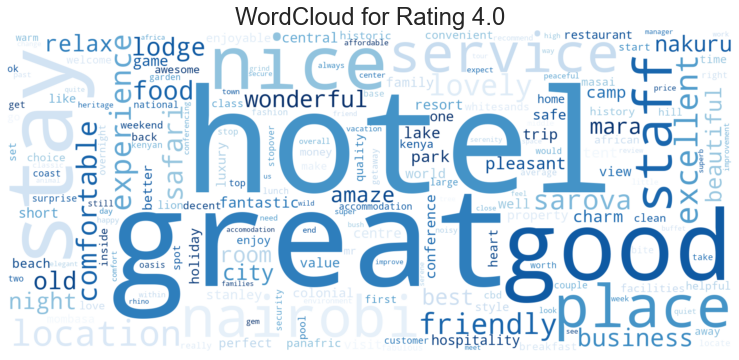

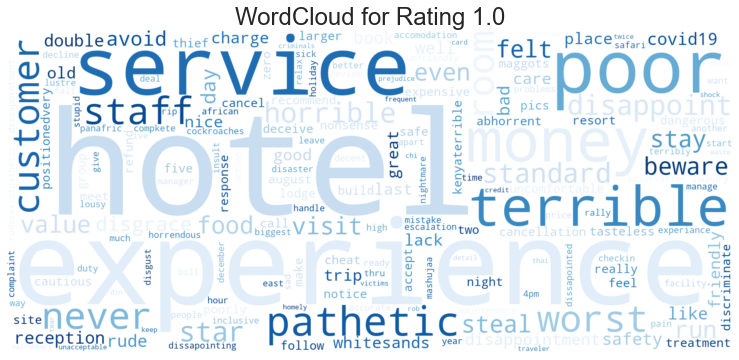

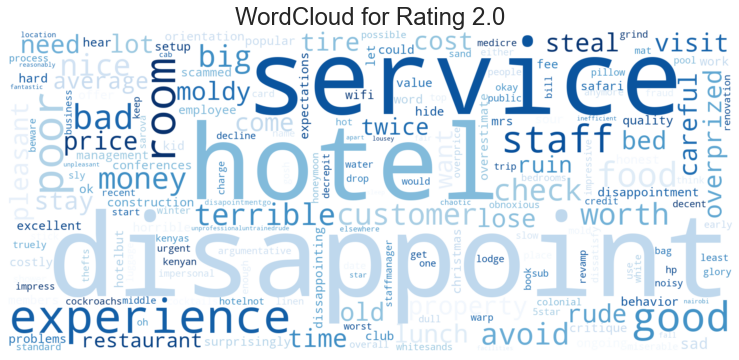

In [70]:
for rating in reviews['rating'].unique():
    display_cloud(rating, reviews, 'title')

In [71]:
from nltk.util import ngrams

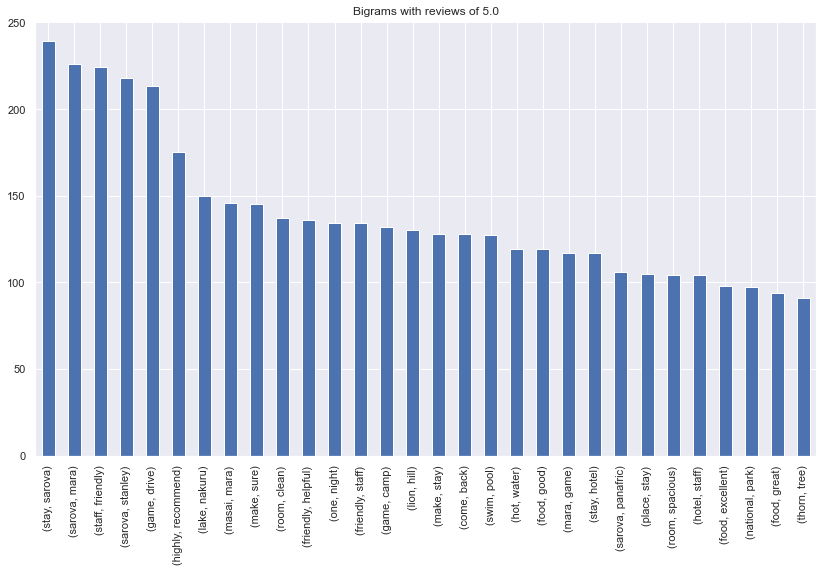

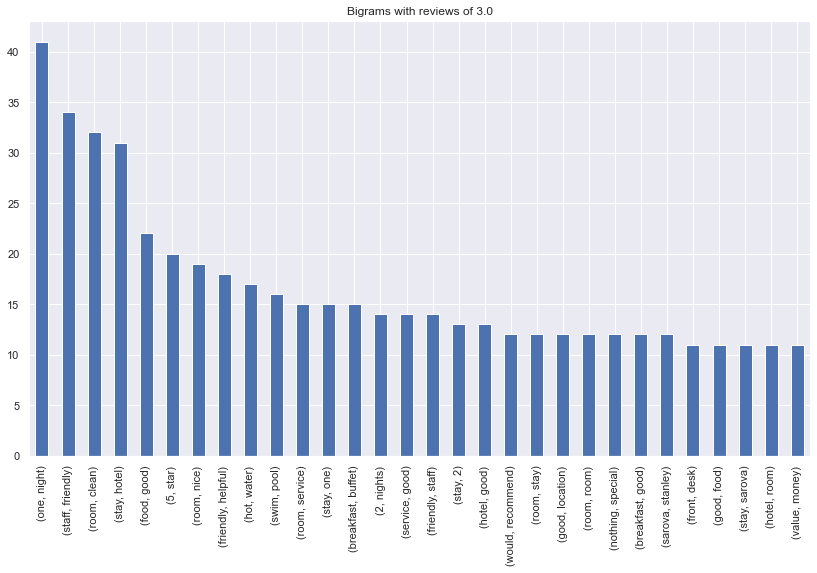

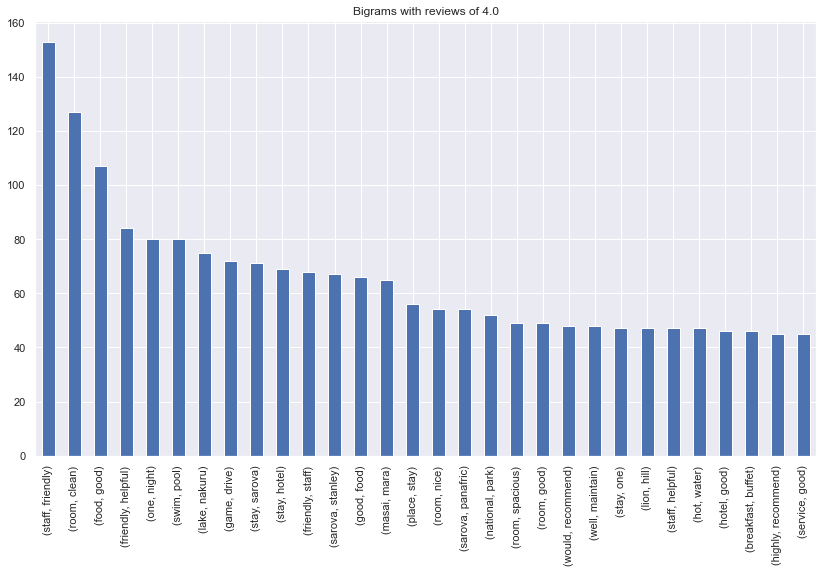

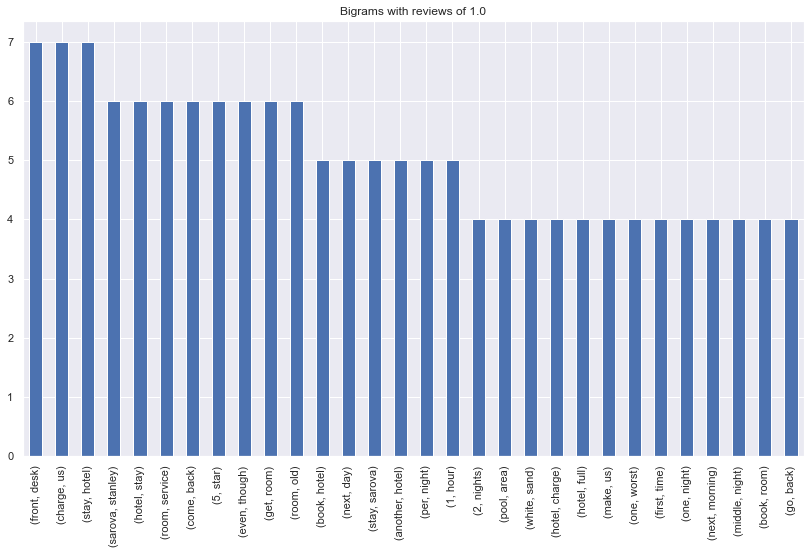

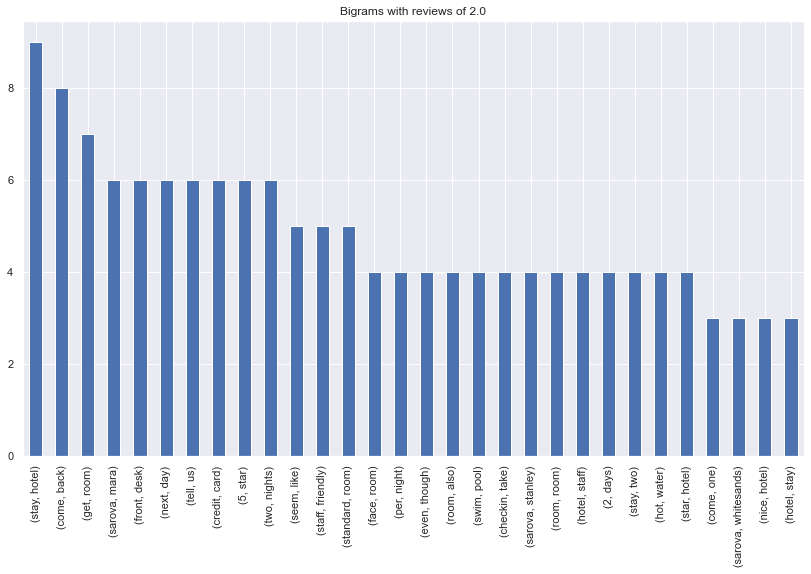

In [74]:
for rating in reviews['rating'].unique():
    review_tokens = [token for review in reviews[reviews['rating'] == rating]['review'] for token in review.split()]
    token_grams = ngrams(review_tokens, 2)
    fdist = FreqDist(token_grams)
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.gca()

    pd.Series(dict(fdist.most_common(30))).plot(kind='bar', ax=ax)
    plt.title('Bigrams with reviews of ' + str(rating))

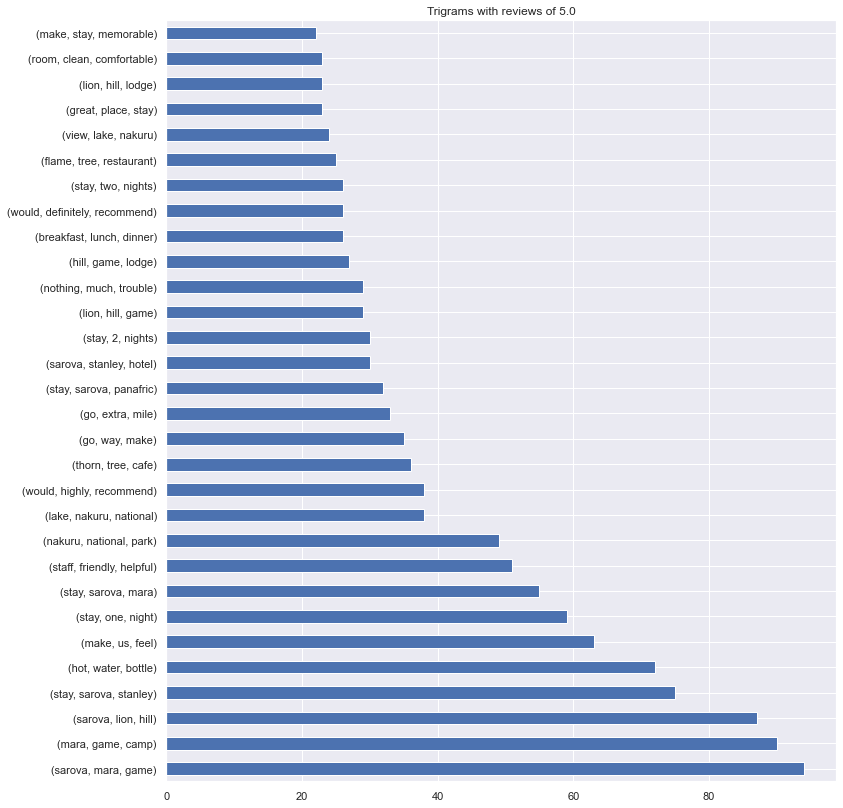

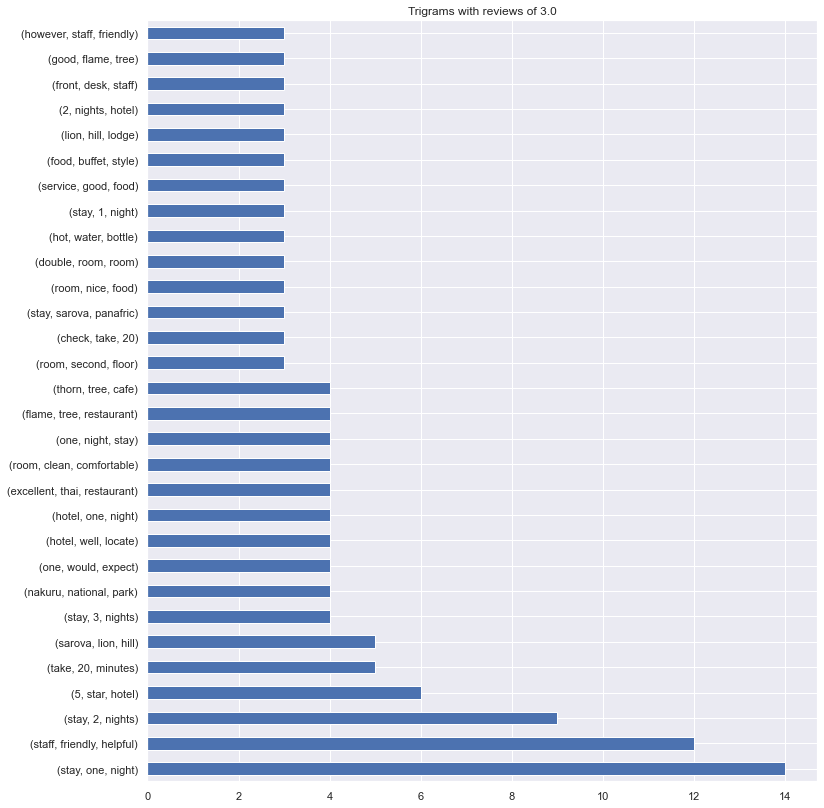

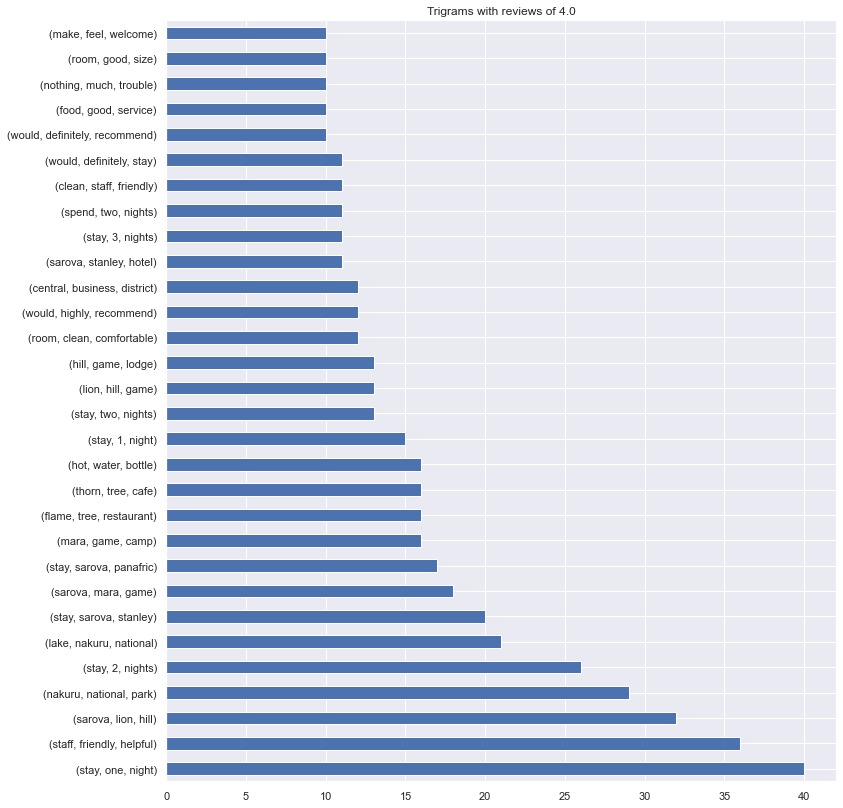

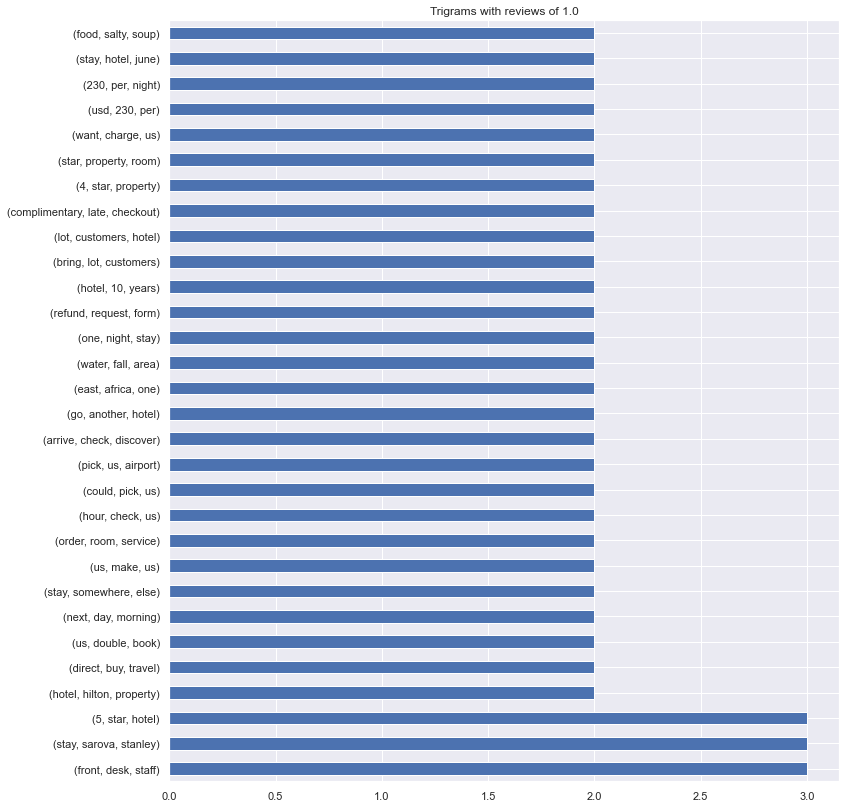

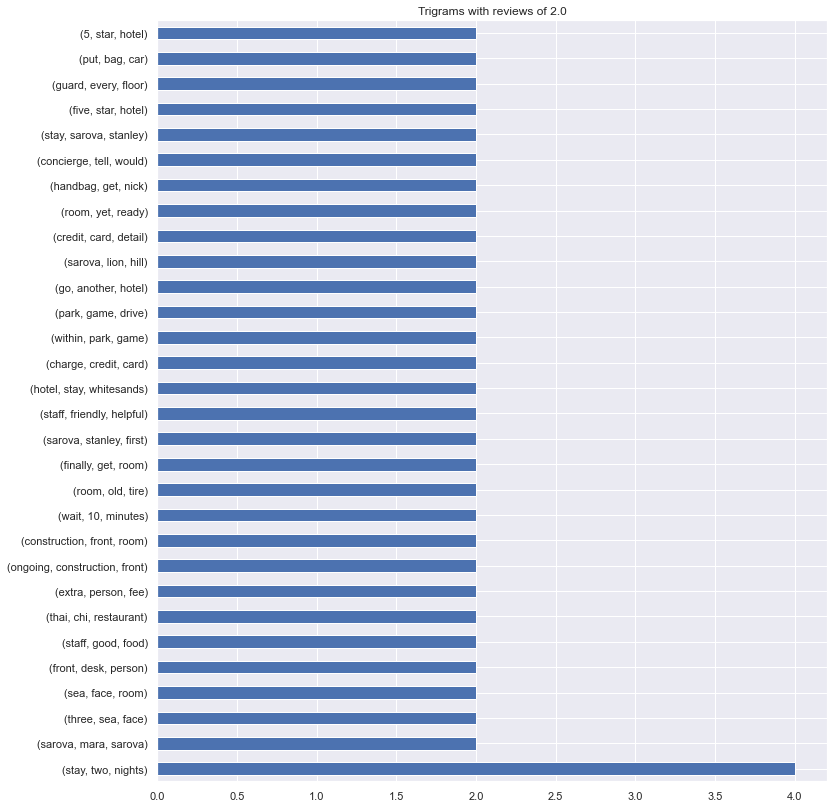

In [77]:
for rating in reviews['rating'].unique():
    review_tokens = [token for review in reviews[reviews['rating'] == rating]['review'] for token in review.split()]
    token_grams = ngrams(review_tokens, 3)
    fdist = FreqDist(token_grams)
    
    fig = plt.figure(figsize=(12,14))
    ax = fig.gca()

    pd.Series(dict(fdist.most_common(30))).plot(kind='barh', ax=ax)
    plt.title('Trigrams with reviews of ' + str(rating))

In [78]:
# Save mapped tweets to file
reviews.to_csv("Preprocessed_Reviews.csv", index=False)